# Bus Parameter Validation

In this notebook we validate the electric bus parameters we'll input to FASTSim. This must be done before we can trust our FASTSim CDMX bus route simulation outputs.

We don't have a lot of great options to validate our simulation output against experimental results, so we'll compare our simulation results to the simulation results from the 2021 LOGIOS study of electrifying bus routes in Mexicali.

In [17]:
import os
import time
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

In [7]:
from fastsim import simdrive, vehicle, cycle

## The LOGIOS drive cycle

Route AB03, recorded on 5/20/21.

In [8]:
# Driving Cycle Data
INPUT_PATH = '../Data/LOGIOS Data/'

# Mexicali Shapefiles. Source: https://www.mexicali.gob.mx/sitioimip/geovisor/layers/geonode:distrito_pducp25/metadata_detail
SHAPEFILE_PATH = '../Data/LOGIOS Data/Mexicali Shapefiles/distrito_pducp25.shp'

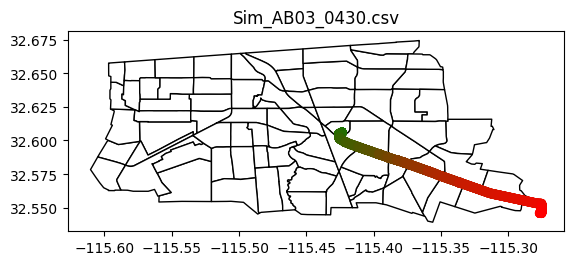

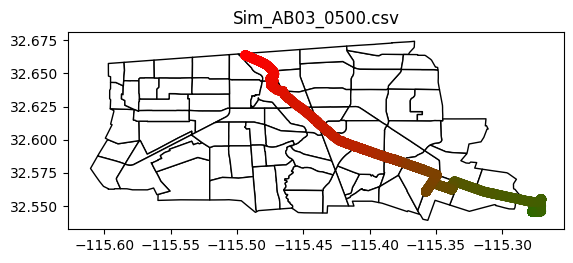

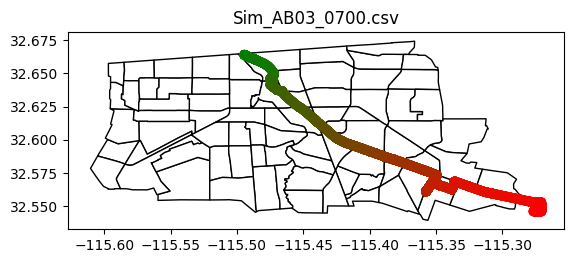

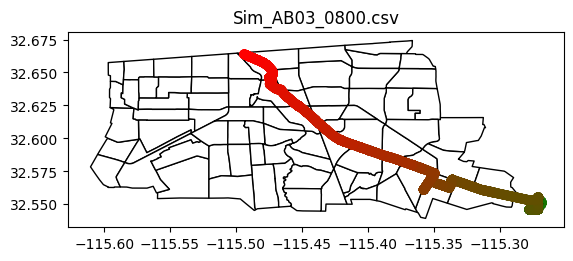

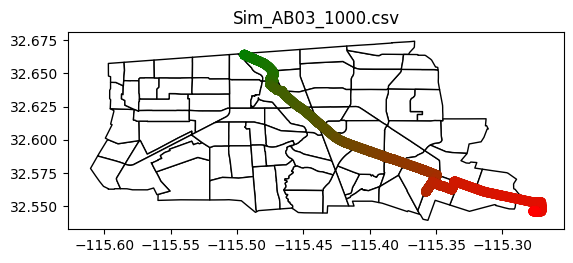

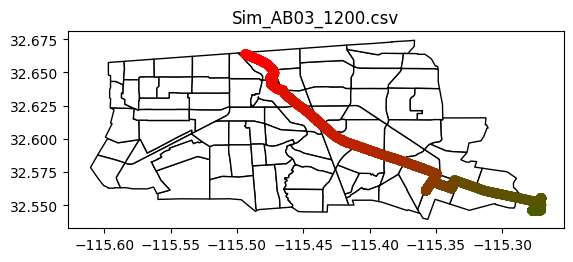

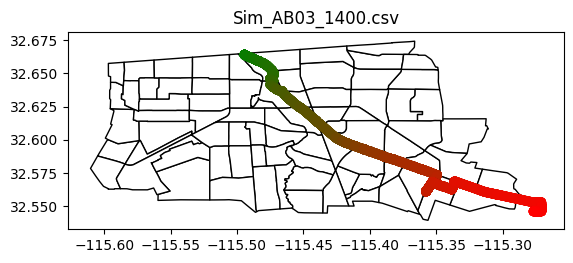

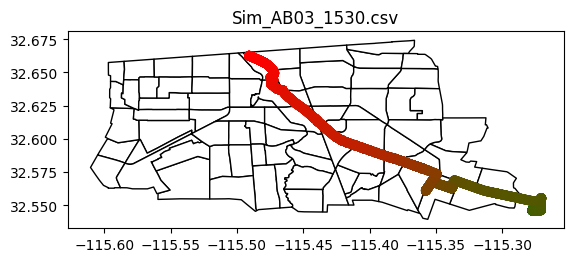

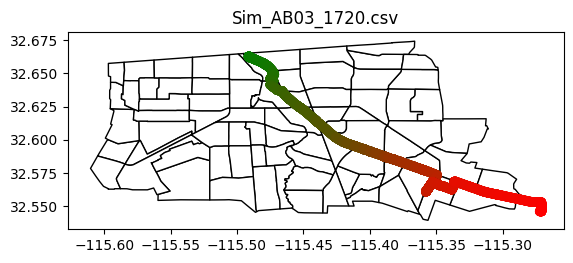

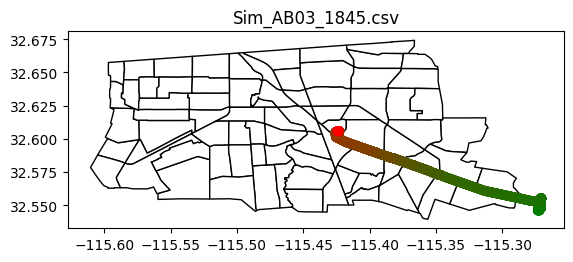

In [9]:
# Load LOGIOS drive cycles
drive_cycles_path = Path(INPUT_PATH) / '0520'
sorted_dc_files = sorted(drive_cycles_path.iterdir(), key=lambda f: str(f))

# Load Mexicali map shapefile
shapefile_path = Path(SHAPEFILE_PATH)
mexicali_map = gpd.read_file(shapefile_path) # At this point GeoDataFrame's CRS is epsg:32611\
mexicali_4326 = mexicali_map.to_crs("EPSG:4326") # Change CRS

# Color the bus route's directionality: Green at start, red at end.
cm = colors.LinearSegmentedColormap.from_list('namewhy', colors=['green', 'red'], N=10000)

# Visualize the route data in each CSV file
for file in sorted_dc_files:
    ax = mexicali_4326.plot(color='white', edgecolor='black')

    df = pd.read_csv(file)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude)) # TODO Try specifying the CRS - see blog post
    gdf.plot(ax=ax, cmap=cm)

    plt.title(f'{file.name}')
    plt.show()

## TODO
- Load LOGIOS drive cycle into FASTSim (along with appropriate bus parameters)
- Run FASTSim and get results
- Produce graphs from the results that can be compared with LOGIOS report graphs

In [23]:
# Concatenate the drive cycle dataframes into the full day's drive cycle
cyc_dfs = [pd.read_csv(file) for file in sorted_dc_files]
cyc_df = pd.concat(cyc_dfs, axis=0)

# Overwrite index and time to be monotonically increasing. The individual cycle files were each re-indexed to 0 by LOGIOS.
cyc_df.Time[:] = range(0,len(cyc_df.Time))
cyc_df.set_index('Time', inplace=True)

# Create a drive cycle dict in a format that FASTSim understands
cyc_dict = {
    'cycSecs': cyc_df.index.to_numpy(),
    'cycMps': cyc_df.Speed.to_numpy(),
    'cycGrade': cyc_df.Slope.to_numpy(),
}

In [27]:
t0 = time.time()
cyc = cycle.Cycle(cyc_dict=cyc_dict)
cyc_jit = cyc.get_numba_cyc()
print(f'Time to load cycle: {time.time() - t0:.2e} s')

Time to load cycle: 4.09e-03 s


In [26]:
t0 = time.time()
veh = vehicle.Vehicle(22) # TODO: This is the tesla, we'll need to enter Bus parameters
veh_jit = veh.get_numba_veh()
print(f'Time to load vehicle: {time.time() - t0:.2e} s')

Time to load vehicle: 2.73e-02 s


In [28]:
# Run our simulation!
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
#initSoc = 0.7935
#sim_drive.essCurKwh[0] = initSoc * sim_drive.veh.maxEssKwh
sim_drive.sim_drive() # REPLACE WITH SIMULATION OF ENERGY CONSUMPTION. TODO what did this comment mean?
print(f'Time to simulate: {time.time() - t0:.2e} s')

t0 = time.time()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()
sim_drive_post.set_battery_wear()
diag = sim_drive_post.get_diagnostics()
print(f'Time to post process: {time.time() - t0:.2e} s')

# TODO: Where's the problem with conservation of energy?

Time to simulate: 3.80e+01 s
Time to post process: 2.17e+00 s


In [29]:
print('Simulation summary:')
print(f'Final S.O.C.: {output["final_soc"]*100:.2f} %')
print(f'Distance driven: {output["distance_mi"]:.2f} miles')

Simulation summary:
Final S.O.C.: 5.00 %
Distance driven: 63.12 miles


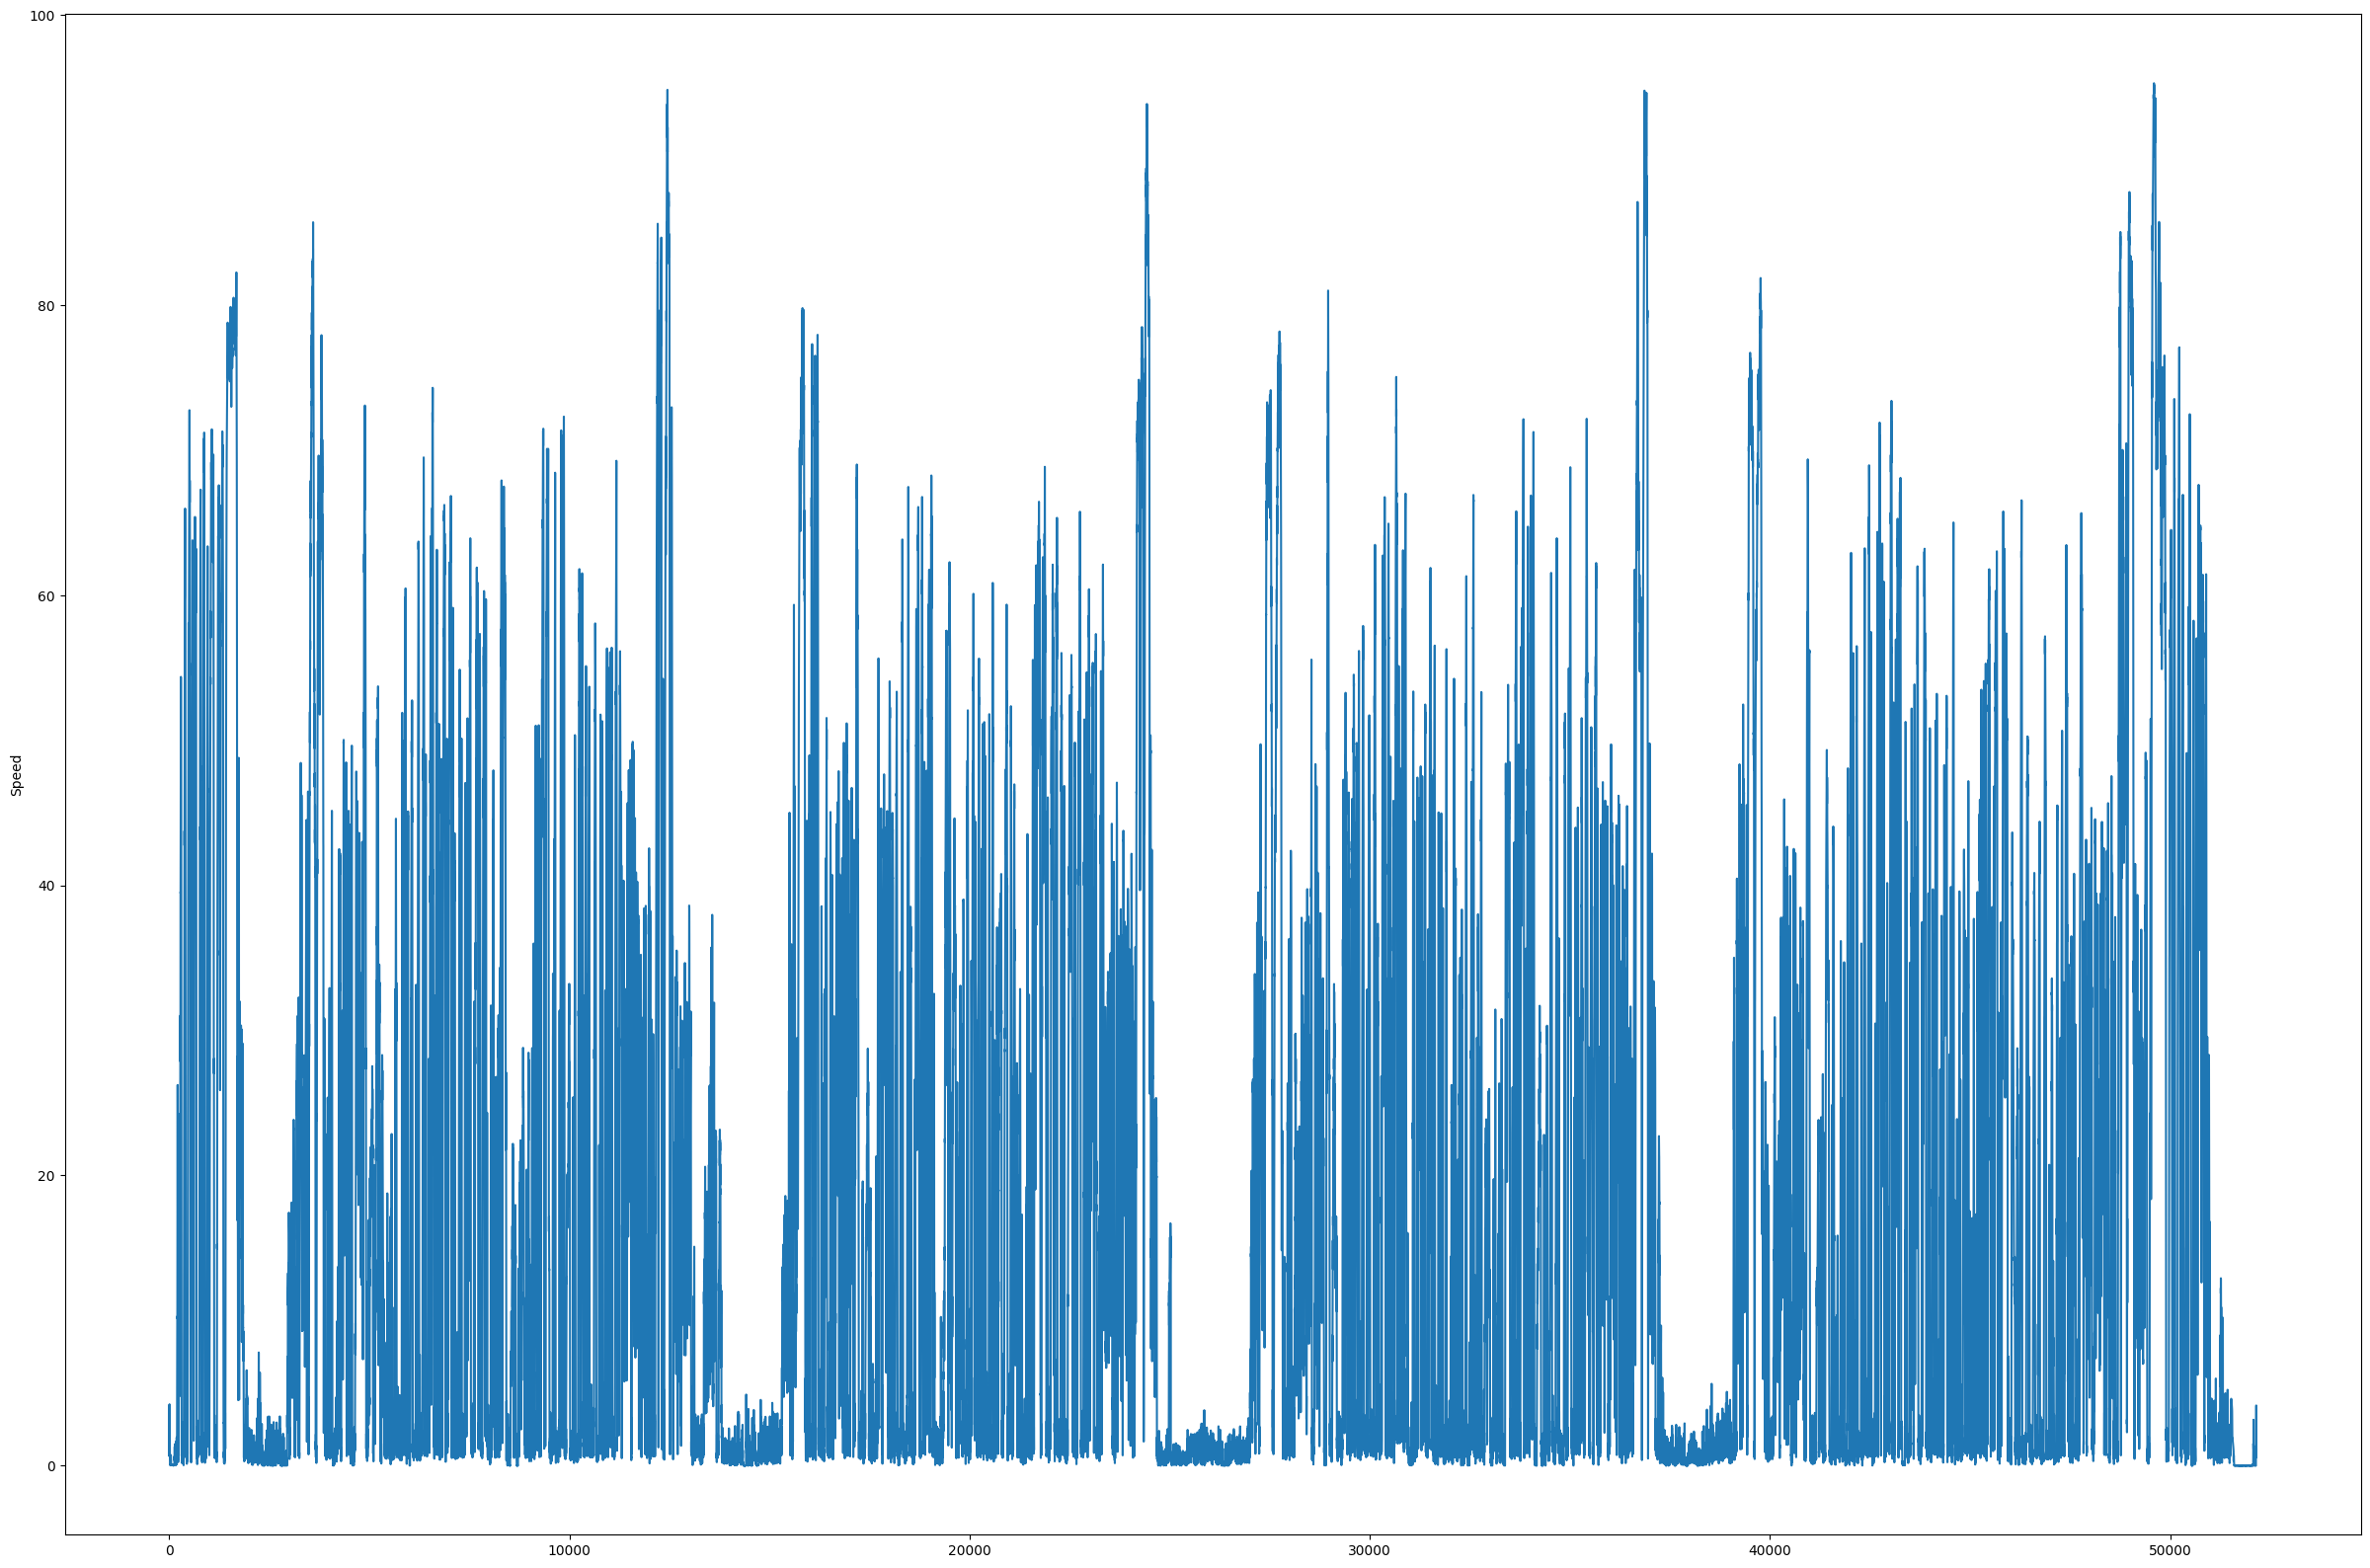

--Return--
None
> <ipython-input-40-02c573142fe1>(11)<module>()
      9 plt.show()
     10 
---> 11 breakpoint()
     12 plt.plot(df['time'],df['distMeters']) # TODO how to access the sim_drive.distMeters - it's not in the output
     13 plt.ylabel('Cumulative Distance (meters)')



ipdb>  sim_drive.distMeters


array([0.        , 0.65678635, 2.73050551, ..., 0.03656899, 0.40472227,
       0.03739412])


ipdb>  len(sim_drive.distMeters)


52156


In [ ]:
# Visualize
df = pd.DataFrame.from_dict(output)
df['speed'] = cyc.cycMps

plt.rcParams['figure.figsize'] = [30, 20]

plt.plot(df['time'],df['speed'])
plt.ylabel('Speed')
plt.show()

breakpoint()
plt.plot(df['time'],df['distMeters']) # TODO Grab sim_drive.distMeters and add it to the output dataframe
plt.ylabel('Cumulative Distance (meters)')
plt.show()

plt.plot(df['time'],sim_drive.fcKwOutAch)
plt.ylabel('Fuel Converter Output')
plt.show()

plt.plot(df['time'],sim_drive.essKwOutAch)
plt.ylabel('Electric Storage System Output')
plt.show()

plt.plot(df['time'],df['soc'])
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['distMeters'],df['soc'])
plt.ylabel('State of Charge / distance')
plt.show()

# TODO so this is saying a Tesla can only last for the first hour of this driving cycle?